In [1]:
import os
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/VehicleClassification
!ls

/content/drive/MyDrive/VehicleClassification
annotations  cars_test	cars_train  saved_model  VehicleClassifier.ipynb


## Preprocessing and loading data

In [29]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory("./cars_train",
                                                            shuffle=True,
                                                            labels=1500*[1]+1500*[0],
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory("./cars_test",
                                                                  shuffle=True,
                                                                  labels=500*[1]+500*[0],
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [30]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [38]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [39]:
preproc_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Train model

In [40]:
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [41]:
gap = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(1)

In [42]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preproc_input(x)
x = base_model(x, training=False)
x = gap(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = dense_layer(x)

model = tf.keras.Model(inputs, outputs)

In [43]:
lr = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [45]:
loss0, acc0 = model.evaluate(validation_dataset)
print("Initial loss: {:.2f}".format(loss0))
print("Initial acc: {:.2f}".format(acc0))

32/32 [==============================] - 138s 3s/step - loss: 0.9188 - accuracy: 0.4860
Initial loss: 0.92
Initial acc: 0.49


In [46]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
94/94 [==============================] - 358s 4s/step - loss: 0.0885 - accuracy: 0.9647 - val_loss: 0.0076 - val_accuracy: 0.9980
Epoch 2/10
94/94 [==============================] - 20s 205ms/step - loss: 0.0366 - accuracy: 0.9903 - val_loss: 0.0106 - val_accuracy: 0.9960
Epoch 3/10
94/94 [==============================] - 20s 206ms/step - loss: 0.0214 - accuracy: 0.9927 - val_loss: 0.0056 - val_accuracy: 0.9990
Epoch 4/10
94/94 [==============================] - 20s 202ms/step - loss: 0.0211 - accuracy: 0.9920 - val_loss: 0.0552 - val_accuracy: 0.9850
Epoch 5/10
94/94 [==============================] - 20s 203ms/step - loss: 0.0353 - accuracy: 0.9900 - val_loss: 0.0504 - val_accuracy: 0.9870
Epoch 6/10
94/94 [==============================] - 20s 205ms/step - loss: 0.0264 - accuracy: 0.9910 - val_loss: 0.0381 - val_accuracy: 0.9900
Epoch 7/10
94/94 [==============================] - 20s 208ms/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.0289 - val_accuracy: 0.9940
E

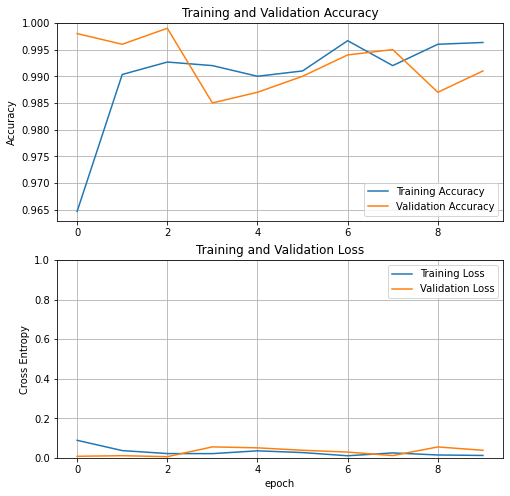

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

In [ ]:
model.save("./saved_model")

## Extra Stuff

In [ ]:
from pycocotools.coco import COCO
import requests

In [ ]:
ann_file = "annotations/instances_{}.json".format('val2017')

In [ ]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=2.13s)
creating index...
index created!


In [ ]:
cats = coco.loadCats(coco.getCatIds())
names = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(names)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [ ]:
# first delete nocar
%rm -f cars_test/nocar/*

num_samples = 150
prefered_cats = ['person', 'table', 'laptop', 'cat', 'horse', 'suitcase', 'ball', 'surfboard',
                 'tennis', 'couch', 'microwave', 'refrigerator', 'chair', 'couch', 'plant', 'tv',
                 'bed', 'remote', 'donut', 'hair']

for cat in prefered_cats:
  print(f"for {cat}:")
  cat_ids = coco.getCatIds(catNms=[cat])
  imgs_id = coco.getImgIds(catIds=cat_ids)
  images = coco.loadImgs(imgs_id)
  for idx, img in enumerate(images):
    if idx == num_samples:
      break
    else:
      if idx % 50 == 0:
        print(f"downloding {idx}'th img")
      raw_data = requests.get(img['coco_url']).content
      with open("cars_test/nocar/"+img['file_name'], 'wb') as writer:
        writer.write(raw_data)
  print("==================")

for person:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for table:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for laptop:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for cat:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for horse:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for suitcase:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for ball:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for surfboard:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for tennis:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for couch:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for microwave:
downloding 0'th img
downloding 50'th img
for refrigerator:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for chair:
downloding 0'th img
downloding 50'th img
downloding 100'th img
for couch:
downloding 0'th img
downloding 